# Quickstart

Showcase for how this package can be used.

## Example data

Let's start by importing the package and getting some mock example timeseries in hourly resolution for a certain customer portfolio.

In [1]:
import portfolyo as pf
import pandas as pd

index = pd.date_range("2024", freq="h", periods=8784, tz="Europe/Berlin")

# Creating market prices (here: forward price curve) timeseries.
ts_prices = pf.dev.p_marketprices(index, avg=200)

# Creating portfolio offtake timeseries.
ts_offtake = -1 * pf.dev.w_offtake(index, avg=50)
# Creating portfolio sourced volume and prices timeseries (of quarter-products).
ts_sourced_power, ts_sourced_price = pf.dev.wp_sourced(ts_offtake, "QS", 0.3, p_avg=120)

## Portfolio lines

By turning the timeseries into 3 "portfolio lines"...

In [2]:
hpfc = pf.PfLine({"p": ts_prices})  # price-only
offtake = pf.PfLine({"w": ts_offtake})  # volume-only
sourced = pf.PfLine({"w": ts_sourced_power, "p": ts_sourced_price})  # price-and-volume

...it becomes easier to do common operations like plotting:

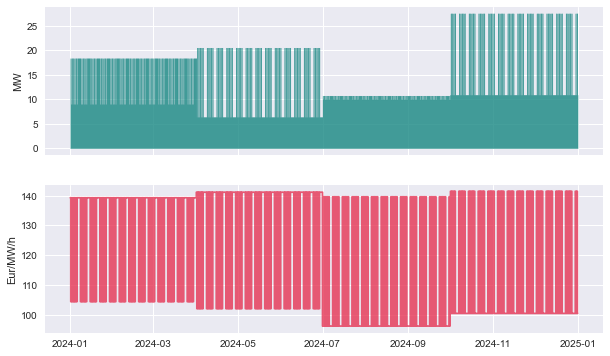

In [3]:
sourced.plot();

...aggregating:

In [4]:
sourced.asfreq("MS")

PfLine object with price and volume information.
. Start: 2024-01-01 00:00:00+01:00 (incl)    . Timezone    : Europe/Berlin  
. End  : 2025-01-01 00:00:00+01:00 (excl)    . Start-of-day: 00:00:00  
. Freq : <MonthBegin> (12 datapoints)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00 +0100         14.9      11 053      131.46     1 453 063
2024-02-01 00:00:00 +0100         14.9      10 398      131.69     1 369 327
2024-03-01 00:00:00 +0100         15.2      11 259      132.27     1 489 298
2024-04-01 00:00:00 +0200         11.5       8 306      115.69       960 908
2024-05-01 00:00:00 +0200         11.6       8 628      115.52       996 763
2024-06-01 00:00:00 +0200         11.1       7 967      117.02       932 229
2024-07-01 00:00:00 +0200         10.4       7 756      111.58       865 442
2024-08-01 00:00:00 +0200         10.4       7 765      110.89       8

...or decomposing into peak- and offpeak values:

In [5]:
sourced.po("QS").pint.dequantify()  # .pint.dequantify() to show units in column header

c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pint_pandas\pint_array.py:194: RuntimeWarning: pint-pandas does not support magnitudes of <class 'int'>. Converting magnitudes to float.
  warnings.warn(


peak                                       \
                          duration          w             q           p   
unit                             h         MW          MW·h     Eur/MWh   
2024-01-01 00:00:00+01:00    780.0   8.969180   6995.960351  104.407521   
2024-04-01 00:00:00+02:00    780.0  20.491010  15982.987566  102.065215   
2024-07-01 00:00:00+02:00    792.0   9.947104   7878.105974  139.604102   
2024-10-01 00:00:00+02:00    792.0  27.475675  21760.734601  141.442611   

                                         offpeak                           \
                                      r duration          w             q   
unit                                Eur        h         MW          MW·h   
2024-01-01 00:00:00+01:00  7.304309e+05   1403.0  18.327806  25713.911223   
2024-04-01 00:00:00+02:00  1.631307e+06   1404.0   6.351754   8917.862478   
2024-07-01 00:00:00+02:00  1.099816e+06   1416.0  10.707181  15161.368636   
2024-10-01 00:00:00+02:00  3.077895e+06   1417.0  10.877807  15413.852057   

                                                     
                                    p             r  
unit                          Eur/MWh           Eur  
2024-01-01 00:00:00+01:00  139.273118  3.581257e+06  
2024-04-01 00:00:00+02:00  141.131612  1.258592e+06  
2024-07-01 00:00:00+02:00   96.223647  1.458882e+06  
2024-10-01 00:00:00+02:00  100.472664  1.548671e+06

## Portfolio state

We can do even more useful analyses by combining the portfolio lines for offtake, sourced, and market prices into a single "portfolio state":

In [6]:
pfs = pf.PfState(offtake, hpfc, sourced)

pfs

PfState object.
. Start: 2024-01-01 00:00:00+01:00 (incl)    . Timezone    : Europe/Berlin  
. End  : 2025-01-01 00:00:00+01:00 (excl)    . Start-of-day: 00:00:00  
. Freq : <Hour> (8784 datapoints)
                                                w           q           p             r
                                               MW         MWh     Eur/MWh           Eur
──────── offtake
           2024-01-01 00:00:00 +0100        -56.6         -57                          
           2024-01-01 01:00:00 +0100        -52.8         -53                          
           ..                                  ..          ..          ..            ..
           2024-12-31 22:00:00 +0100        -67.7         -68                          
           2024-12-31 23:00:00 +0100        -62.7         -63                          
─●────── pnl_cost
 │         2024-01-01 00:00:00 +0100         56.6          57      201.02        11 372
 │         2024-01-01 01:00:00 +0100         52.8          53 

This object can also be resampled to other frequencies:

In [7]:
pfs_months = pfs.asfreq("MS")

We can see how much of the offtake volume is still unsourced, and how much we expect to pay for it, as a portfolio line. We can obtain it in the original frequency with `pfs.unsourced`, or in monthly frequency with `pfs_monthly.unsourced`. We can of course also chain the methods:

In [8]:
pfs.asfreq("MS").unsourced  # or: pfs.unsourced.asfreq('MS')

PfLine object with price and volume information.
. Start: 2024-01-01 00:00:00+01:00 (incl)    . Timezone    : Europe/Berlin  
. End  : 2025-01-01 00:00:00+01:00 (excl)    . Start-of-day: 00:00:00  
. Freq : <MonthBegin> (12 datapoints)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00 +0100         49.7      36 990      255.70     9 458 395
2024-02-01 00:00:00 +0100         48.2      33 567      240.85     8 084 500
2024-03-01 00:00:00 +0100         44.2      32 848      213.46     7 011 828
2024-04-01 00:00:00 +0200         43.3      31 147      174.37     5 431 217
2024-05-01 00:00:00 +0200         38.3      28 484      145.33     4 139 700
2024-06-01 00:00:00 +0200         34.6      24 882      123.65     3 076 521
2024-07-01 00:00:00 +0200         34.4      25 583      136.56     3 493 569
2024-08-01 00:00:00 +0200         35.5      26 390      145.96     3 8

Plotting is also possible:

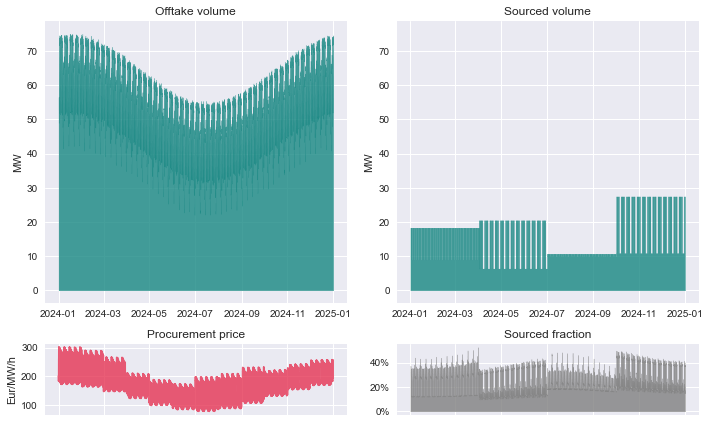

In [9]:
pfs.plot();

We can see how much it would cost to perfectly hedge the entire offtake volume, based on what has already been sourced (and its price) and what is still unsourced (valued at market prices). This is available at `pfl.pnl_cost`. Let's look at this, graphically, in month values:

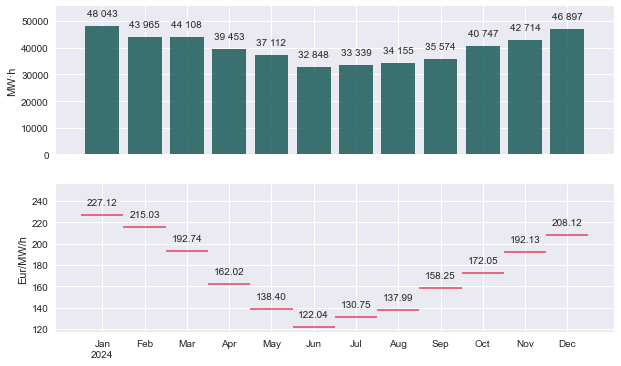

In [10]:
pfs.pnl_cost.asfreq("MS").plot();

On average, only about 30% of the portfolio has currently been hedged. This can be seen from the `pfs.plot()` output, or we can calculate the fractions explicitly:

In [11]:
pfs.asfreq("MS").sourcedfraction  # not pfs.sourcedfraction.asfreq("MS") !
# (.sourcedfraction is a pandas Series, which does not average when applying .asfreq("MS"))

2024-01-01 00:00:00+01:00    0.23006370221556163
2024-02-01 00:00:00+01:00    0.23650210243151373
2024-03-01 00:00:00+01:00     0.2552667409134675
2024-04-01 00:00:00+02:00     0.2105305001508305
2024-05-01 00:00:00+02:00     0.2324871900458479
2024-06-01 00:00:00+02:00     0.2425302180631649
2024-07-01 00:00:00+02:00    0.23264967847113516
2024-08-01 00:00:00+02:00    0.22735797840772143
2024-09-01 00:00:00+02:00     0.2113212510546372
2024-10-01 00:00:00+02:00    0.31131448354888985
2024-11-01 00:00:00+01:00    0.28128161731884777
2024-12-01 00:00:00+01:00    0.26600630185450264
Freq: MS, Name: fraction, dtype: pint[]

This means that an increase in the market prices will have a relatively large impact, especially in the months with a low sourced fraction. Let's verify that. 

First, we create a new price curve, and then create a new portfolio state with it. Then, we again look at the ``.pnl_cost`` property, to see the new procurement prices:

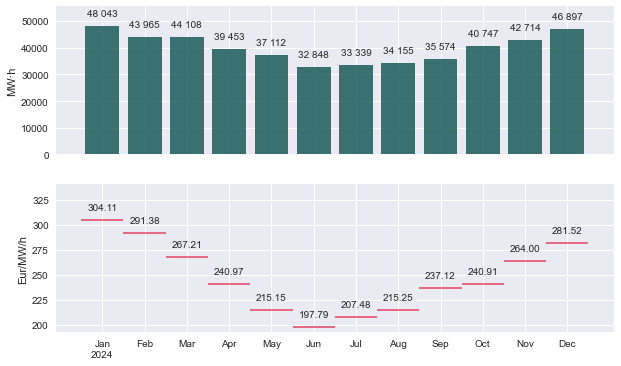

In [12]:
hpfc2 = hpfc + pf.Q_(100.0, "Eur/MWh")
pfs2 = pfs.set_unsourcedprice(hpfc2)
pfs2.pnl_cost.asfreq("MS").plot();

We could even explicitly calculate the monthly price increases:

In [13]:
pfs2.asfreq("MS").pnl_cost.p - pfs.asfreq("MS").pnl_cost.p

2024-01-01 00:00:00+01:00    76.99362977844379
2024-02-01 00:00:00+01:00     76.3497897568486
2024-03-01 00:00:00+01:00    74.47332590865318
2024-04-01 00:00:00+02:00    78.94694998491693
2024-05-01 00:00:00+02:00    76.75128099541516
2024-06-01 00:00:00+02:00    75.74697819368352
2024-07-01 00:00:00+02:00    76.73503215288648
2024-08-01 00:00:00+02:00    77.26420215922792
2024-09-01 00:00:00+02:00    78.86787489453633
2024-10-01 00:00:00+02:00    68.86855164511101
2024-11-01 00:00:00+01:00     71.8718382681152
2024-12-01 00:00:00+01:00    73.39936981454974
Freq: MS, Name: p, dtype: pint[Eur/MWh]

Indeed, the 100 Eur/MWh across-the-board market price increase has impacted the months exactly in proportion to the fraction that is still unsourced. So, a month that is 60% hedged sees a 40 Eur/MWh impact in its procurement price.

That's it for this quick introduction. Have a look at the more in-depth [tutorial](part1.ipynb) or the more systematic documentation of the [PfLine](../core/pfline.rst) or [PfState](../core/pfstate.rst) classes.